In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
from itertools import islice
from pathlib import Path

In [2]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.field_names import FieldName

from pts.model.time_grad import TimeGradEstimator
from pts import Trainer


/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
import loaders.fi2010_loader as loader

In [4]:
# Load the data of the F1-2010 Dataset for each individual asset
Asset1 = loader.Dataset_fi2010('NoAuction', 'Zscore', [0], [1], 20, 0, False)
Asset2 = loader.Dataset_fi2010('NoAuction', 'Zscore', [1], [1], 20, 1, False)
Asset3 = loader.Dataset_fi2010('NoAuction', 'Zscore', [2], [1], 20, 2, False)
Asset4 = loader.Dataset_fi2010('NoAuction', 'Zscore', [3], [1], 20, 3, False)
Asset5 = loader.Dataset_fi2010('NoAuction', 'Zscore', [4], [1], 20, 4, False)

In [5]:
PREDICTION_LENGTH = 50

In [6]:
def create_dataset(data, period=PREDICTION_LENGTH):

    target = data

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate(
        (np.zeros((data.shape[0], period)), target[:, :-period]), axis=1
    )

    return target, feat_dynamic_real

In [7]:
Asset1.x_raw.shape

(3945, 144)

In [8]:
# define the parameters of the dataset
custom_ds_metadata = {
    "num_series": Asset1.x_raw.shape[1],
    "num_steps":  Asset1.x_raw.shape[0],
    "prediction_length": PREDICTION_LENGTH,
    "freq": "1H",
    "start": [pd.Period('2000-01-01 00:00:00', freq="1H").to_timestamp() for _ in range(Asset1.x_raw.shape[1])],
}

In [9]:
data_out = create_dataset(Asset1.x_raw.T)

target, feat_dynamic_real = data_out

In [10]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
        }
        for (target, start, fdr) in zip(
            target[:, : -custom_ds_metadata["prediction_length"]],
            custom_ds_metadata["start"],
            feat_dynamic_real[:, : -custom_ds_metadata["prediction_length"]],
        )
    ],
    freq=custom_ds_metadata["freq"],
)

In [11]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
        }
        for (target, start, fdr) in zip(
            target, custom_ds_metadata["start"], feat_dynamic_real
        )
    ],
    freq=custom_ds_metadata["freq"],
)

In [12]:
train_entry = next(iter(train_ds))
train_entry.keys()

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(


dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])

In [13]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


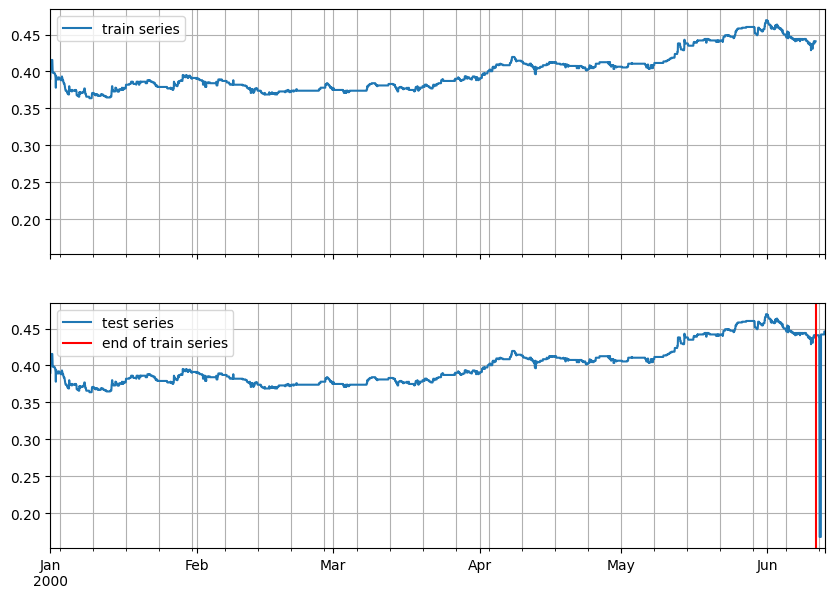

In [14]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [15]:
train_series.head()

2000-01-01 00:00:00    0.390233
2000-01-01 01:00:00    0.404428
2000-01-01 02:00:00    0.404428
2000-01-01 03:00:00    0.404428
2000-01-01 04:00:00    0.404428
Freq: H, dtype: float32

In [16]:
train_grouper = MultivariateGrouper(max_target_dim=144)
test_grouper = MultivariateGrouper(max_target_dim=144)

In [17]:
dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self.frequency = timestamp.freq
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:217: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:166: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = TimeGradEstimator(
    target_dim=144,
    prediction_length=PREDICTION_LENGTH,
    context_length=24,
    cell_type='GRU',
    num_cells=128,
    input_size=580,
    loss_type='l2',
    diff_steps=80,
    beta_end=0.15,
    freq="1H",
    scaling=False,
    trainer=Trainer(device=device,
                    epochs=10,
                    learning_rate=1e-6,
                    maximum_learning_rate = 1e-3,
                    num_batches_per_epoch=30,
                    batch_size=10)
)
                                            
                                            
predictor = estimator.train(training_data=dataset_train, num_workers=4)

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.wa

  0%|          | 0/29 [00:03<?, ?it/s]

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.wa

  0%|          | 0/29 [00:03<?, ?it/s]

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.wa

  0%|          | 0/29 [02:07<?, ?it/s]

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/si

  0%|          | 0/29 [00:04<?, ?it/s]

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.wa

  0%|          | 0/29 [00:05<?, ?it/s]

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.wa

KeyboardInterrupt: 

In [19]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [20]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [21]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=20)

In [22]:
forecasts = list(forecast_it)

/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/si

In [23]:
tss = list(ts_it)

In [24]:
def save_list_to_file(lst, filename):
    with open(filename, 'w') as file:
        for item in lst:
            file.write(str(item) + '\n')

In [88]:
save_list_to_file(tss[0][5], "temp.txt")

IndexError: list index out of range

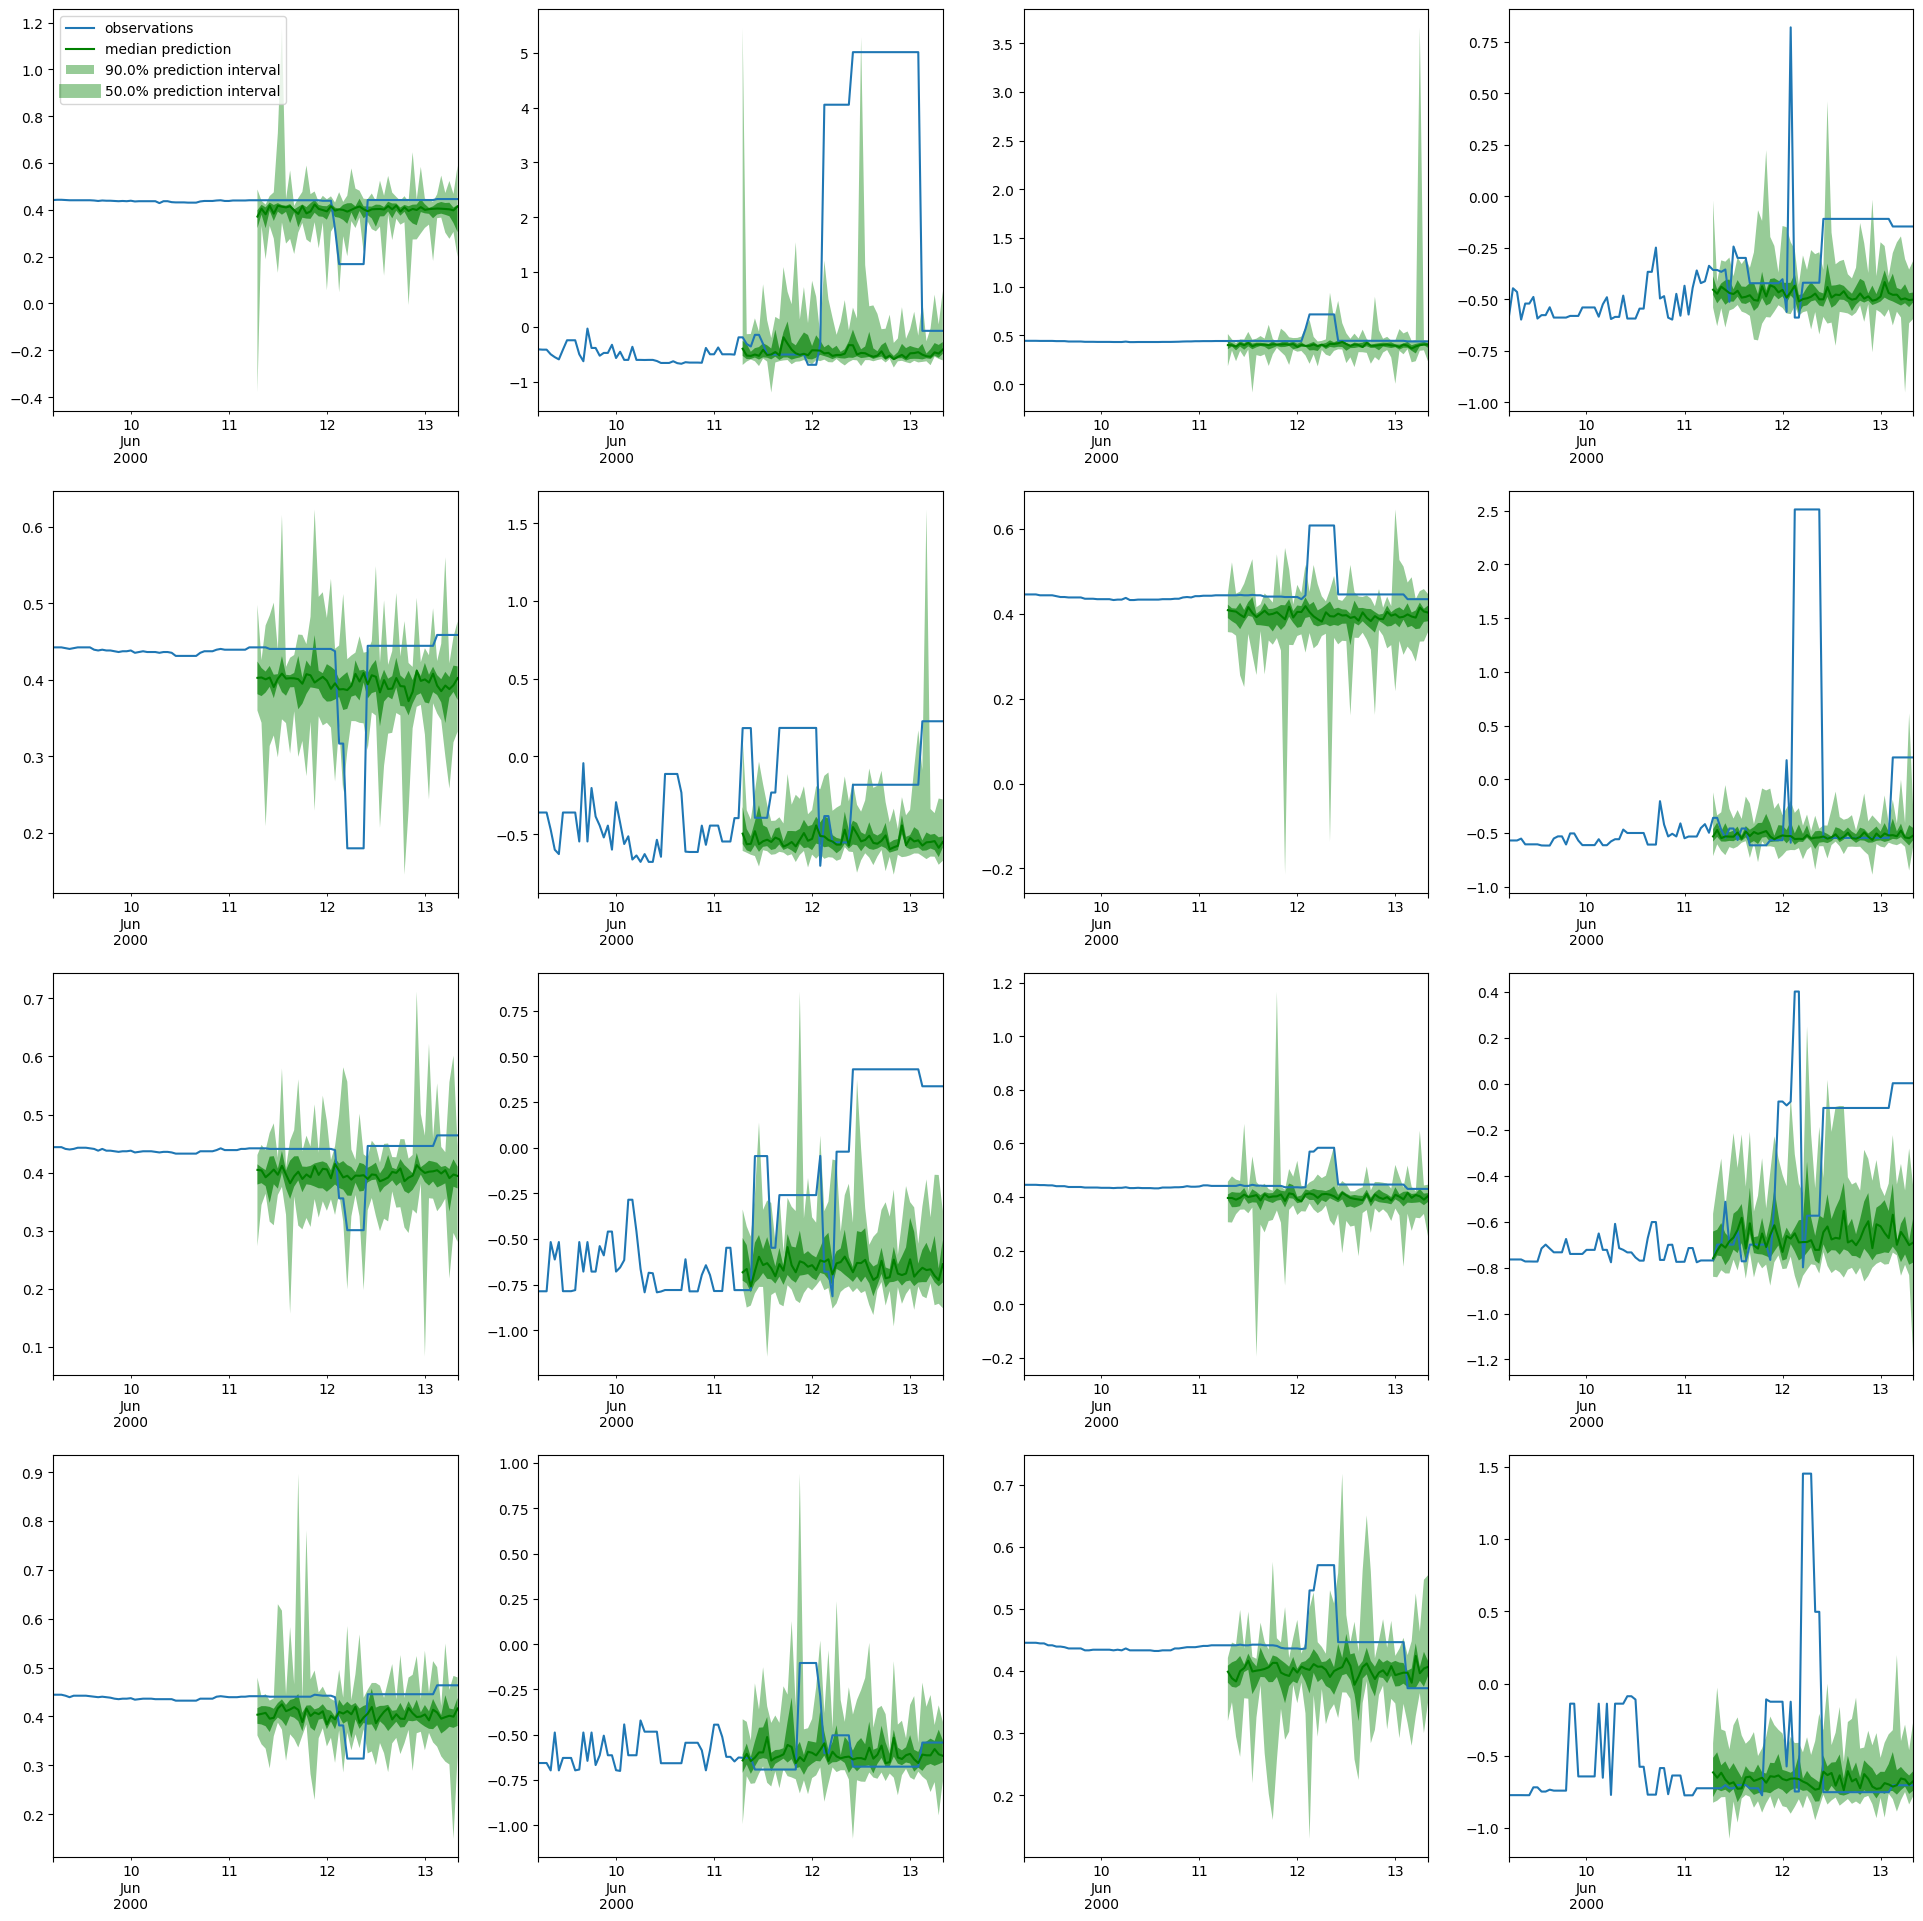

In [27]:
plot(
    target= tss[0],
    forecast=forecasts[0],
    prediction_length= custom_ds_metadata["prediction_length"],
)
plt.show()

In [30]:
from gluonts.evaluation import Evaluator

In [32]:
len(dataset_test)

1

In [41]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 1it [00:00, 12.10it/s]
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pygame_env/lib/python3.10/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq


ValueError: operands could not be broadcast together with shapes (144,50) (50,144) 